In [21]:
from Binaries import *

def MoPS_compatibility(signal : np.ndarray) -> bool : 

    # assumes we're fed 120 bin trace windows
    y_min, y_max = 3, 31                                                        # only accept y_rise in this range
    min_slope_length = 2                                                        # minimum number of increasing bins
    min_occupancy = 4                                                           # positive steps per PMT for trigger
    pmt_multiplicity = 2                                                        # required multiplicity for PMTs
    pmt_active_counter = 0                                                      # actual multiplicity for PMTs
    integral_check = 75 * 120/250                                               # integral must pass this threshold


    for pmt in signal:

        # check for the modified integral first, computationally easier
        if sum(pmt) * GLOBAL.q_peak <= integral_check: continue
        
        occupancy = 0
        positive_steps = np.nonzero(np.diff(pmt) > 0)[0]
        steps_isolated = np.split(positive_steps, np.where(np.diff(positive_steps) != 1)[0] + 1)
        candidate_flanks = [step for step in steps_isolated if len(step) >= min_slope_length]
        candidate_flanks = [np.append(flank, flank[-1] + 1) for flank in candidate_flanks]

        for i, flank in enumerate(candidate_flanks):

            # adjust searching area after encountering a positive flank
            total_y_rise = (pmt[flank[-1]] - pmt[flank[0]]) * GLOBAL.q_peak

            n_continue_at_index = flank[-1] + max(0, int(np.log2(total_y_rise) - 2))

            for j, consecutive_flank in enumerate(candidate_flanks[i + 1:], 0):

                if n_continue_at_index <= consecutive_flank[0]: break                                                       # no overlap, no need to do anything
                elif consecutive_flank[0] < n_continue_at_index <= consecutive_flank[-1]:                                   # partial overlap, adjust next flank
                    overlap_index = np.argmin(np.abs(consecutive_flank - n_continue_at_index))
                    candidate_flanks[i + j] = candidate_flanks[i + j][overlap_index:]
                    if len(candidate_flanks[i + j]) < min_slope_length: _ = candidate_flanks.pop(i + j)
                    break

                elif consecutive_flank[-1] < n_continue_at_index:                                                           # complete overlap, discard next flank
                    _ = candidate_flanks.pop(i + j)

            if total_y_rise > y_min and total_y_rise < y_max: occupancy += 1
        if occupancy > min_occupancy: pmt_active_counter += 1
        
    return pmt_active_counter >= pmt_multiplicity

_ = MoPS_compatibility(window)


In [27]:
MoPS = HardwareClassifier(["mops"])
EverythingElse = HardwareClassifier(["th", "tot", "totd"])

Events = EventGenerator("all", apply_downsampling = True, real_background = False)

StopIteration: 

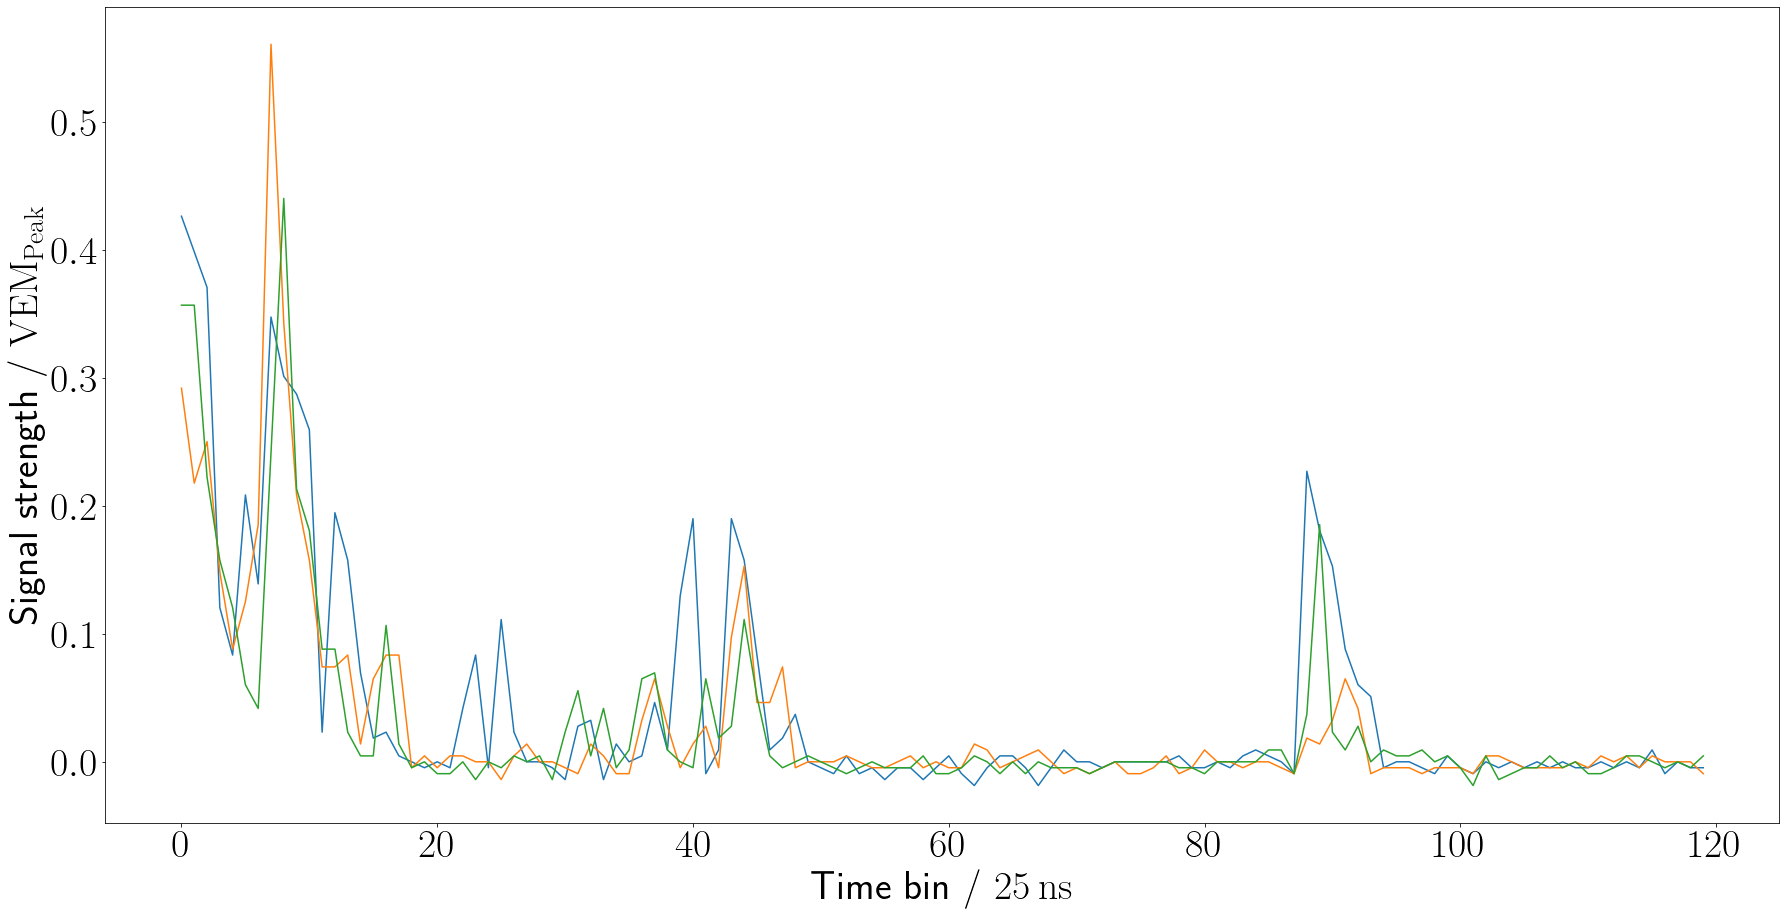

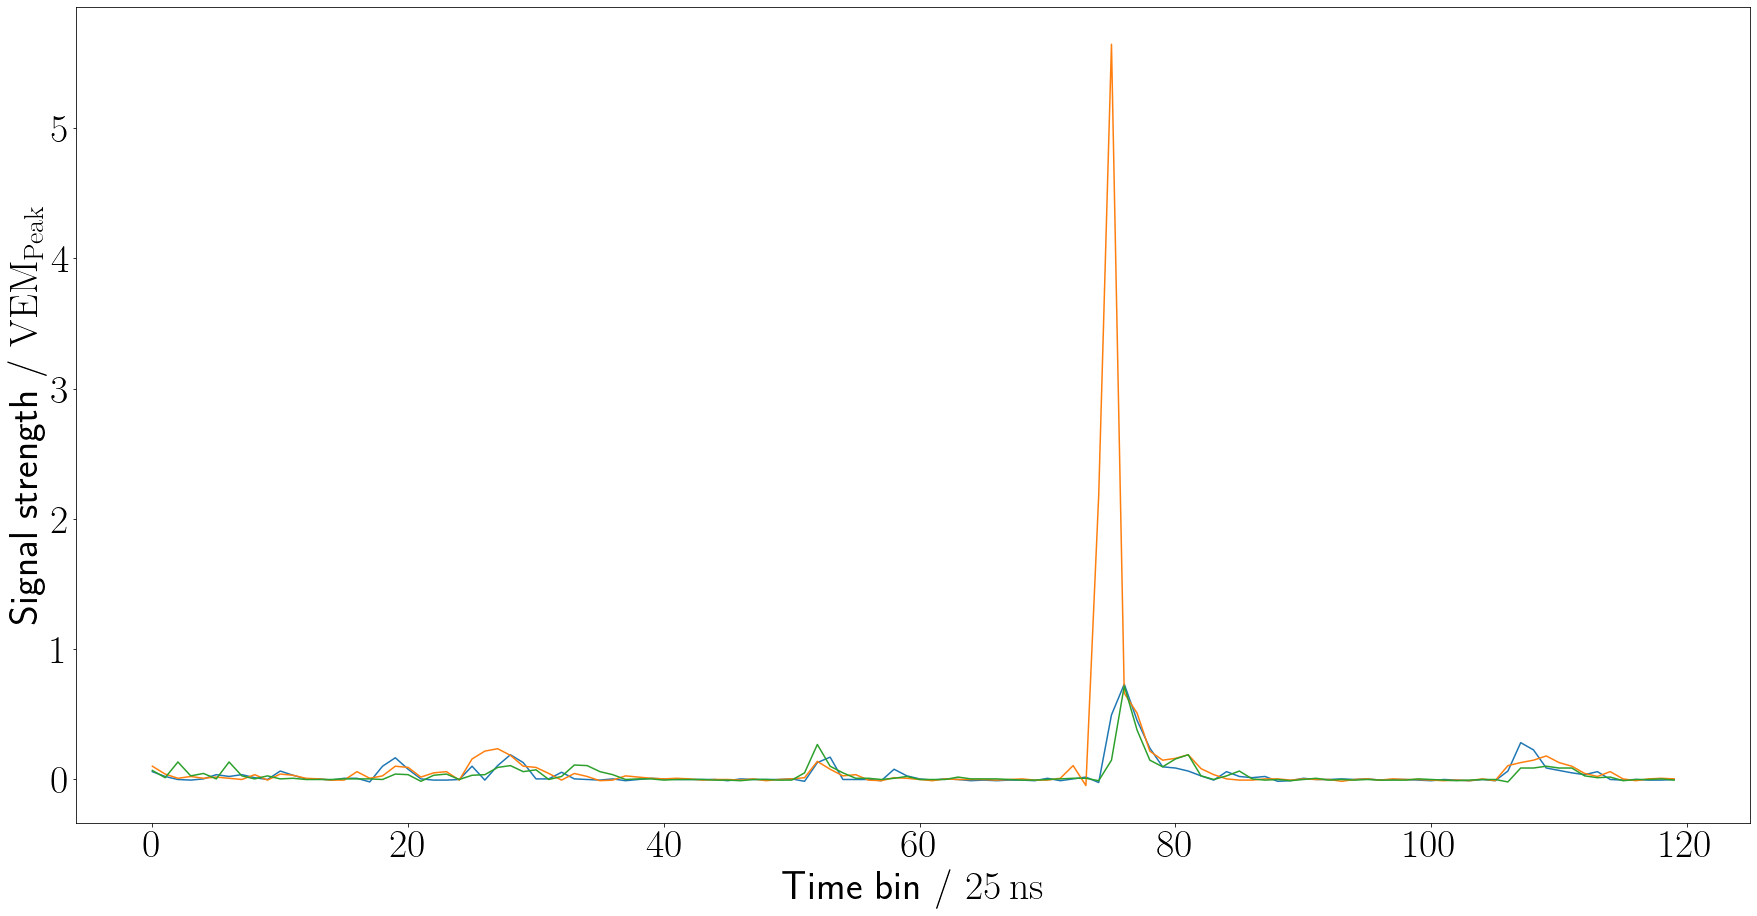

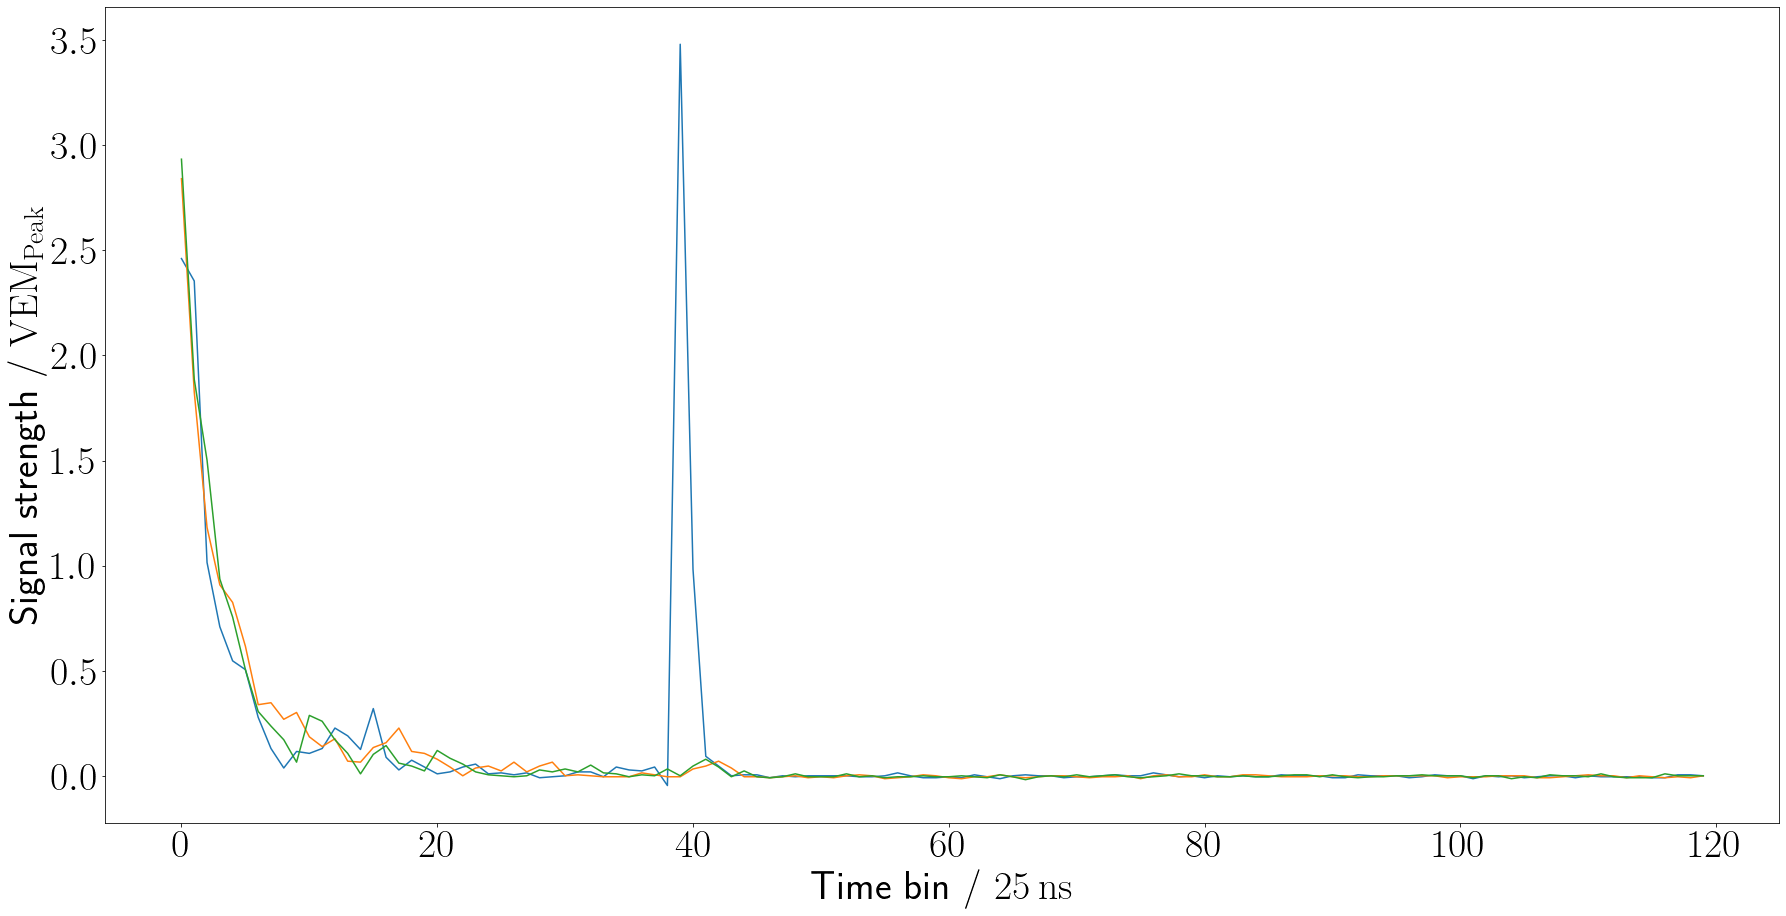

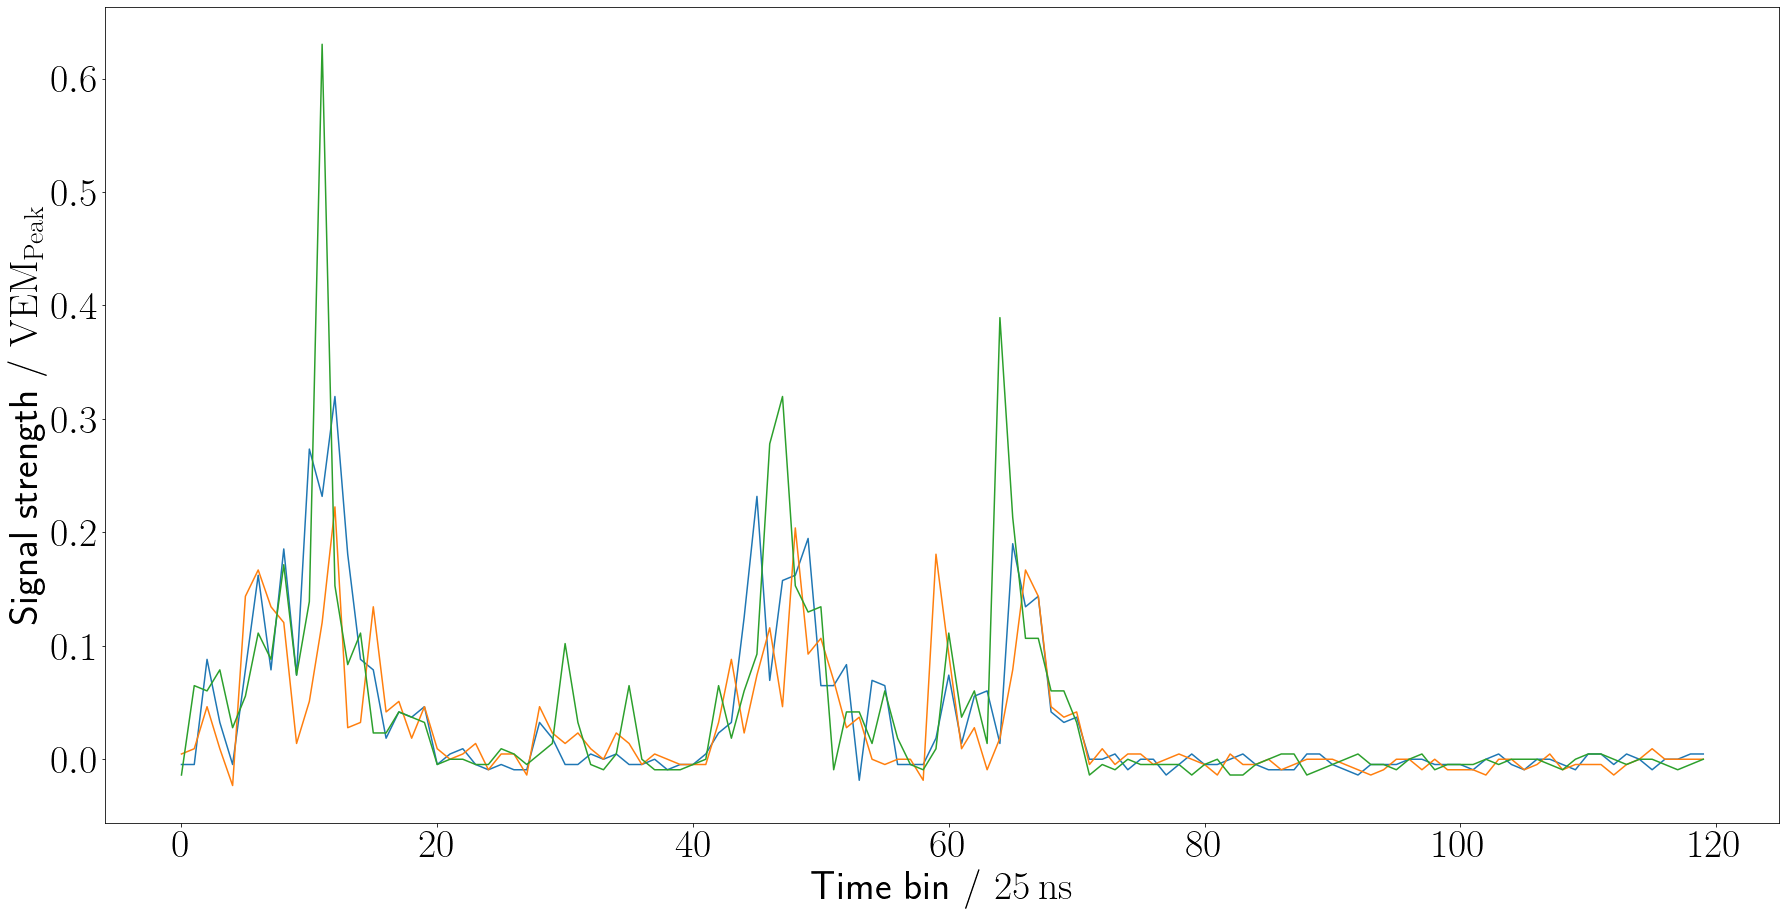

In [34]:
n_found = 0

for traces, labels in Events[0]:

    for window in traces:

        if not EverythingElse(window):
            if MoPS_compatibility(window):

                n_found += 1

                plt.figure()
                plt.xlabel("Time bin / $25\,\mathrm{ns}$")
                plt.ylabel("Signal strength / $\mathrm{VEM}_\mathrm{Peak}$")
                plt.plot(range(120), window[0])
                plt.plot(range(120), window[1])
                plt.plot(range(120), window[2])

                break

        if n_found >= 4: raise StopIteration


    # break